# 1. General

## 1.1 Import Libraries

Here, Important libraries are imported:

In [1]:
# General 
from enum import Enum
import os
import subprocess
import pickle

# Data Preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler

# Datastructures
import pandas as pd
import numpy as np

# Modeling 
import tensorflow as tf
from tensorflow import keras

# Expirement Tracking
import mlflow

# Visualization
import matplotlib.pyplot as plt
import seaborn as sb

2024-05-03 22:26:36.452134: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 22:26:36.501543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 22:26:36.501590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 22:26:36.503108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 22:26:36.527920: I tensorflow/core/platform/cpu_feature_guar

## 1.2 Project Pathes

Here, the pathes for the project folder, data subfolder, etc are encapsulated in 2 Enums, one for local pathes, and the other for remote ones :

In [2]:
## 1.2 Project Pathes
class localpath(Enum):
            
    root = '/mnt/d/projects'  # The root directory for the project, shall be changed whenever the project is moved
    project = os.path.join(root,'Device-Price-Classification')
    __data = os.path.join(project,'data')
    data_raw= os.path.join(__data,'raw')
    data_interim = os.path.join(__data,'interim')
    data_processed = os.path.join(__data,'processed')
    models = os.path.join(project,'models')

/tmp/ipykernel_86583/3220258835.py:6: DeprecationWarning: private variables, such as '_localpath__data', will be normal attributes in 3.11
  __data = os.path.join(project,'data')


## 1.3 Services and Servers

Here, a MLflow server is instantiated at http://127.0.0.1:8080:

In [3]:
process = subprocess.Popen(['mlflow', 'server', '--host', '127.0.0.1', '--port', '8080'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

A tensorboard server is instantiated at:

In [4]:
#%load_ext tensorboard


# 2. Data Loader

In this section, the DataLoader calss is utilized to load data from the online HF source to the local drive. Then, it is loaded from the local drive to the RAM.

- **Note**: Since the data size is very small, it is accepted that we load it directly to ram instead of designing a data pipeline.

In [5]:
class CSVDataLoader:
    """A class to load training and testing data from CSV files.

    Attributes:
        raw_dir (str): The directory containing the CSV files.
        train_prefix (str): The prefix of the CSV filename for the training data (e.g., "data_train.csv").
        test_prefix (str): The prefix of the CSV filename for the test data (e.g., "data_test.csv").
        n_attempts (int, optional): The number of trials to load the data if an exception is raised. Defaults to 3.
        delimiter (str, optional): The delimiter used in the CSV files. Defaults to ",".
        val_split (float, optional): The proportion of data to use for the validation set (0.0 to 1.0). Defaults to 0.2.
        stratify_by (str, optional): The column name for the variable used to stratify the training/validation split.
                                     If None, stratification will be ignored Defaults to None.
    """ 


    def __init__(self, raw_dir:str,train_prefix:str, test_prefix:str, n_attempts:int=3,delimiter:str=",",val_split:float=0.2, stratify_by:str=None):
        # Inititalize constructor inputs as object attributes
        self.raw_dir = raw_dir
        self.train_prefix = train_prefix
        self.test_prefix = test_prefix
        self.delimiter = delimiter
        self.val_split=val_split
        self.n_attempts =n_attempts
        self.stratify_by= stratify_by
        # Containers for the train,test, val datasets
        self.train_data=None
        self.test_data=None
        self.val_data=None
        # Load the data to the class object
        self.__load_data()

    def __load_data(self):
        """
        A private method to load the data from the csv files and split the training data set into train/validation
        """
        # Read data from testing CSV file
        test_path = os.path.join(self.raw_dir,self.test_prefix)
        self.test_data= self.__csv_reader(test_path)
        
        # Read data from training CSV file
        train_path = os.path.join(self.raw_dir,self.train_prefix)
        train_data= self.__csv_reader(train_path)

        # Split training data to train and validation data
        self.train_data,self.val_data= train_test_split(train_data,test_size=self.val_split, stratify= train_data[self.stratify_by])

    def __csv_reader(self,file_path:str)->pd.DataFrame:
        """A private method to read the csv file into a pandas dataframe

        Args:
            file_path (str): The path of the CSV file

        Returns:
            df (pd.DataFrame): The pandas DataFrame containing the data in the given CSV file
        """
        df=None
        for attempt in range(self.n_attempts):
            try:
                df = pd.read_csv(filepath_or_buffer=file_path, delimiter=self.delimiter,index_col=False)
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
            else:
                print(f'Data Loaded successfully from the local path:{file_path}')
                break
        return df

    def get_train_data(self)->pd.DataFrame:
        """
        Returns the training data.
        """
        return self.train_data

    def get_test_data(self)->pd.DataFrame:
        """
        Returns the testing data.
        """
        return self.test_data

    def get_val_data(self)->pd.DataFrame:
        """
        Returns the testing data.
        """
        return self.val_data
    
    def save_data(self,destination_dir:str):
        """saves the train, val, test datasets into CSV files

        Args:
            destination_dir (str): The local path to save the files.
        """        
        train_path = os.path.join(destination_dir,'train_data.csv')
        test_path = os.path.join(destination_dir,'test_data.csv')
        val_path = os.path.join(destination_dir,'val_data.csv')

        self.train_data.to_csv(path_or_buf=train_path)
        self.test_data.to_csv(path_or_buf=test_path)
        self.val_data.to_csv(path_or_buf=val_path)

    def __repr__(self) -> str:
            return 'DataLoader'
    


In [6]:
#Initialize the DataLoader 
data_loader = CSVDataLoader(raw_dir= localpath.data_raw.value, train_prefix ='train_data.csv',test_prefix ='test_data.csv',stratify_by='price_range' )
#load data from local drive
data_train = data_loader.get_train_data()
data_val = data_loader.get_val_data()
data_test = data_loader.get_test_data()
# Saves the data locally
data_loader.save_data(localpath.data_interim.value)


Data Loaded successfully from the local path:/mnt/d/projects/Device-Price-Classification/data/raw/test_data.csv
Data Loaded successfully from the local path:/mnt/d/projects/Device-Price-Classification/data/raw/train_data.csv


# 3. Exploratory Data Analysis (EDA)

In this section, review data is explored in order to understand patterns in the data. This may help us take suitable decisions while modeling. 

## 3.1 Helper Classes / Functions

In [7]:
def print_shape(X:pd.DataFrame):
    """Prints the shape of a pandas dataframe

    Args:
        X (pd.DataFrame):  The pandas dataframe under examination

    """    
    for name, value in globals().items():
        if value is X:
           X.name= name 

    if type(X) == pd.core.series.Series:
        print ("The",X.name ,"series"+" has",X.shape[0]," rows")  
        
    elif type(X) == pd.core.frame.DataFrame:
    
        print ("The",X.name ,"dataframe"+" has",X.shape[0]," rows and",X.shape[1] ,"columns" ) 
        
    return None

In [8]:
def print_df(df:pd.DataFrame,n:int=5, max_col:int=None, max_rows:int=None, random:bool=True, flatten_col:bool=False):
    """_summary_

    Args:
        df (Pandas.Dataframe) : The pandas dataframe under examination
        n (int): number of rows to print
        max_col(int): maximum number of columns to print. If None, all the columns will be printed
        max_rows(int): maximum number of rows to print. If None, all the rows will be printed
        random (Bool): If True, random n samples will be printed
        flatten_col:(Bool): If True, all the cell content will be printed

   
    """    
    #setting the maximum number of columns and rows to be printed
    pd.set_option( "display.max_columns", max_col, "display.max_rows", max_rows)
    if flatten_col:
        pd.set_option( "display.max_colwidth", None) 
    
    #Sampling an n random rows from the dataframe to be displayed
    if random: 
        row_indices = np.random.randint(0,df.shape[0],n)
    elif random == False:
        row_indices= range(0,n)
    
    #printing the dataframe
    print("\033[1m The", df.name,"dataframe:" )
    display(df.iloc[row_indices,:])
    

In [9]:
def list_missingness(df:pd.DataFrame, only_missing:bool=False, percentage:bool=True):
    """_summary_

    Args:
        df (pd.DataFrame): The pandas dataframe under examination
        only_missing (bool, optional):  If True, only columns with non zero missingness will be printed.
        percentage (bool, optional): If True, the missingness percentage will be returned instead of numbers.
    Returns:
        nan_per_col: number/percent of missing values in each column
    """      
    nan_per_col = df.isnull().sum(axis = 0).sort_values(ascending = False)
    nan_per_row = df.isnull().any(axis=1).sum()
    if only_missing:
        nan_per_col = nan_per_col.loc[nan_per_col!=0] 
    
    
    if percentage:
        nan_per_col = (nan_per_col /len(df))*100

    print(f"The total numbe of rows with missing values are: {nan_per_row} which is {nan_per_row/len(df)}% of the data.\n" )
    print(f"The missingness percentage for each variable in {'%' if percentage else'numbers'}:\n{nan_per_col}")
    
    return nan_per_col

In [10]:
def plot_binary_dist(df:pd.DataFrame, cat_var:str, labels:list):
    """Plots the distribution of a  two-class variable in a bar plotummary_

    Args:
        df (Pandas.DataFrame): The pandas dataframe containing the categorical variable under examination
        cat_var (str): The categorical variable under examination
        labels (list): name of the mapping labels for the cat_var
    """    
    plt.figure(figsize=(10,4))
    sb.countplot(x = df[cat_var],hue =df[cat_var],legend = False, palette= ['r','g'])#,, legend=False)
    plt.xlabel(cat_var)
    plt.xticks([0,1], list(labels))
    plt.ylabel("Count of "+ labels[0]+" & "+labels[1])
    plt.title("Distribution of the "+cat_var+" variable")
    plt.show()

In [11]:
def plot_ordinal_dist(df:pd.DataFrame, cat_var:str):
    """Plots the distribution of a one class variable in a bar plot
   

    Args:
        df (Pandas.DataFrame): The pandas dataframe containing the categorical variable under examination
        cat_var (str): name of the mapping labels for the variable
    """            
    plt.figure(figsize=(10,4))
    sb.countplot(x = df[cat_var],hue =df[cat_var],legend = False,)#,, legend=False)
    plt.xlabel(cat_var)
    plt.ylabel(f"Count of {cat_var}")
    plt.title(f"Distribution of the {cat_var} variable")
    plt.show()

In [12]:
def plot_categorical_vs_target(df:pd.DataFrame ,cat_var:str,hue:str,rotate_xticks:bool=False):
    """Plots the distribution of a one class variable versus values of the target variable

    Args:
        df (pd.DataFrame): The pandas dataframe containing the categorical variable under examination
        cat_var (str): name of the column containing the variable under examination
        hue (str): name of the column containing the target variable
        rotate_xticks (bool, optional): if true, the xlabel labels will be rotated. Defaults to False.
    """    
    
    #value_counts of cat_var
    counts = df[cat_var].value_counts()
    counts_df = pd.DataFrame({'var': counts.index,'counts': counts.values})

    #calculating the percentage of hue per cat_var
    cat_perc = df[[cat_var, hue]].groupby([cat_var],as_index=False).mean()
    cat_perc[hue] = cat_perc[hue]*100
    cat_perc.sort_values(by=hue, ascending=False, inplace=True)
    
    fig, ax= plt.subplots(figsize=(15,5))

        
    #plotting the calsses distribution for each target value
    s1 = sb.countplot(ax=ax, x = cat_var, data=df, hue =hue, order=cat_perc[cat_var])
    ax.set_title(f"Distribution of {cat_var} for each {hue}", fontdict={'fontsize' : 15, 'fontweight' : 3, 'color' : 'Blue'}) 
    if(rotate_xticks):
        s1.set_xticklabels(s1.get_xticklabels(),rotation=50)
    
    plt.show()
    
    return None

In [13]:
def plot_cont_dist(df:pd.DataFrame ,cont_var:str):
    """Plots the distribution of a continues variable versus values of the target variable

    Args:
        df (pd.DataFrame): The pandas dataframe containing the continues variable under examination
        cont_var (str): ame of the column containing the variable under examination
    """    
    # xlim
    min = 0.7* df[cont_var].min()
    max = 1.05* df[cont_var].max()  
    
    fig, ax = plt.subplots(figsize=(10,5))

    #plotting the variable distribution
    s1 = sb.histplot(ax = ax, data = df, x = cont_var, stat = 'density' , element= 'step')
    ax.set_xlim(min,max)
    ax.legend([cont_var], loc ="upper right")    
    ax.set_title(cont_var + ' distribution', fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'}) 


In [14]:
def plot_corr(df:pd.DataFrame,method:str='spearman',figsize:tuple=(7, 5)):
    """Plots the correlation heatmap

    Args:
        df (pd.DataFrame): The pandas dataframe containing the continues all the variables
        method (str, optional): The correlation method. Defaults to 'spearman'.
        figsize (tuple, optional): The matplotlib figure size. Defaults to (7, 5).
    """    
    # Calculate the correlation matrix between variables
    correlation = df.corr(method= method)
    # Create mask to hide upper triangle
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    f, ax = plt.subplots(figsize=figsize)
    sb.heatmap(correlation,cmap="Blues",linewidth=.5,mask=mask,ax=ax)
    ax.set_title(f"{method} Correlation Heat Map")
    plt.show()


## 3.2 Prelimenary EDA

### 3.2.1 Dataset in table form


In [15]:
#p Printing the shapes of the dataset splits
print_shape(data_train)
print_shape(data_val)
print_shape(data_test)

The data_train dataframe has 1600  rows and 21 columns
The data_val dataframe has 400  rows and 21 columns
The data_test dataframe has 1000  rows and 21 columns


In [16]:
# printing the training dataset
print_df(df=data_train,flatten_col=True)

 The data_train dataframe:


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
609,1212,0,2.6,0,1.0,1.0,46.0,0.3,102.0,4.0,8.0,611.0,1715.0,2249.0,14.0,3.0,4,1,1,1,2
1679,1470,1,1.7,1,6.0,0.0,45.0,0.1,121.0,1.0,9.0,777.0,1090.0,3259.0,10.0,1.0,14,1,0,1,3
918,979,0,0.5,1,0.0,1.0,5.0,0.5,164.0,7.0,2.0,793.0,1670.0,3449.0,5.0,2.0,14,1,0,0,3
1194,1299,0,2.8,1,2.0,0.0,60.0,0.8,187.0,8.0,6.0,1333.0,1838.0,1412.0,13.0,1.0,20,0,1,1,1
590,612,1,0.7,0,6.0,0.0,35.0,0.6,181.0,5.0,12.0,1294.0,1337.0,3169.0,14.0,9.0,6,0,0,0,2


### 3.2.2 Statistical Properties and Datatypes

In [17]:
# description of all variables, including all datatypes
data_train.describe(include='all')

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,1600.000000,1600.000000,1600.000000,1600.000000,1597.000000,1597.000000,1597.000000,1596.000000,1597.000000,1597.000000,1596.000000,1596.000000,1598.000000,1598.000000,1599.000000,1599.000000,1600.000000,1600.000000,1600.000000,1600.00000,1600.000000
mean,1231.195000,0.496875,1.518938,0.510000,4.289292,0.515341,32.410144,0.499561,140.549781,4.510958,9.917920,648.401003,1255.061952,2118.446183,12.413383,5.793621,11.060625,0.760625,0.498750,0.50250,1.500000
std,439.638214,0.500147,0.820141,0.500056,4.283086,0.499921,18.256429,0.290206,35.178023,2.297849,6.025039,446.714688,432.547967,1088.155551,4.207074,4.412967,5.423245,0.426835,0.500155,0.50015,1.118384
min,501.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000
25%,843.750000,0.000000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,110.000000,3.000000,5.000000,286.000000,876.250000,1201.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.00000,0.750000
50%,1219.500000,0.000000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,569.500000,1256.000000,2123.000000,13.000000,5.000000,11.000000,1.000000,0.000000,1.00000,1.500000
75%,1607.750000,1.000000,2.200000,1.000000,7.000000,1.000000,49.000000,0.800000,170.000000,7.000000,15.000000,951.000000,1633.750000,3075.250000,16.000000,9.000000,16.000000,1.000000,1.000000,1.00000,2.250000
max,1998.000000,1.000000,3.000000,1.000000,18.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.00000,3.000000


In [18]:
data_train['sc_h'].value_counts()

sc_h
17.0    162
12.0    129
16.0    114
7.0     114
15.0    111
13.0    110
14.0    109
10.0    102
19.0    102
18.0    100
9.0      96
8.0      94
11.0     94
6.0      86
5.0      76
Name: count, dtype: int64

In [19]:
data_train['sc_w'].value_counts()

sc_w
3.0     166
1.0     163
0.0     152
4.0     145
5.0     126
2.0     120
8.0     102
6.0     100
7.0      97
10.0     87
9.0      76
11.0     72
12.0     50
13.0     43
15.0     27
16.0     26
14.0     25
17.0     14
18.0      8
Name: count, dtype: int64

In [20]:
data_train['talk_time'].value_counts()

talk_time
4     101
7      96
16     94
15     94
18     92
19     92
6      90
14     85
8      84
11     84
13     82
10     81
17     80
5      79
9      77
12     76
3      73
2      71
20     69
Name: count, dtype: int64

**Comments:** <br>
- The dataset includes variables that we are sure they are categorical.Those variables are: <br>[blue,dual_sim,four_g, n_cores, three_g, touch_screen, wifi, price_range].
- The variables [sc_h, sc_w, talk_time] has been investigated by printing the number of unique values.
- **Binary categorical variables:** [blue,dual_sim,four_g,three_g,touch_screen,wifi].
- **Ordinal Categorical Variables:** [n_cores,sc_h,sc_w,talk_time,price_range]. (They are already in a suitable format for being fed to a model).


## 3.3 Missingness Analysis

In [21]:
# print missing values report
missing_perc =list_missingness(df=data_train, only_missing=False,
                               percentage=True)

The total numbe of rows with missing values are: 7 which is 0.004375% of the data.

The missingness percentage for each variable in %:
pc               0.2500
m_dep            0.2500
px_height        0.2500
fc               0.1875
four_g           0.1875
int_memory       0.1875
mobile_wt        0.1875
n_cores          0.1875
px_width         0.1250
ram              0.1250
sc_h             0.0625
sc_w             0.0625
talk_time        0.0000
wifi             0.0000
touch_screen     0.0000
three_g          0.0000
battery_power    0.0000
blue             0.0000
dual_sim         0.0000
clock_speed      0.0000
price_range      0.0000
dtype: float64


**Comment**: Since The percentage of rows with missing values is very low, list-wise delteion will be applied. <br> Also, No further analysis shall be done for the missingness.

## 3.4 Categorical Variable EDA

### 3.4.1 Univariate Categorical EDA

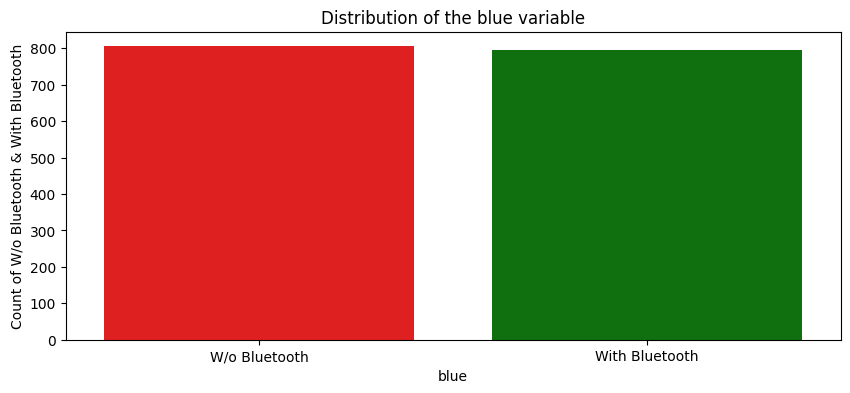

In [22]:
plot_binary_dist(df=data_train,cat_var='blue', labels=['W/o Bluetooth','With Bluetooth'])

**Comments:** <br>
- The number of devices with bluetooth and those without are almost identical.


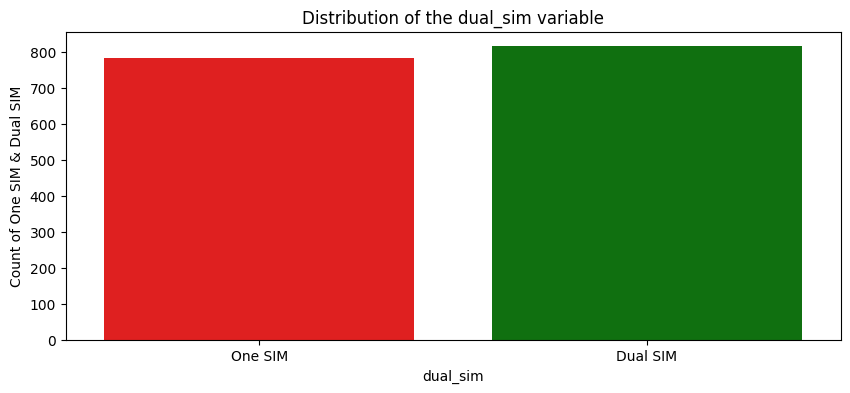

In [23]:
plot_binary_dist(df=data_train,cat_var='dual_sim', labels=['One SIM','Dual SIM'])

**Comments:** <br>
- - The number of devices with dual-sim and those with only one are almost identical.
 


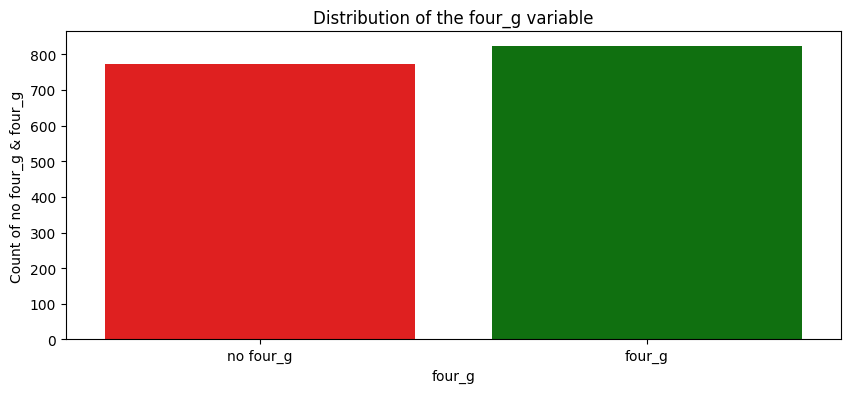

In [24]:
plot_binary_dist(df=data_train,cat_var='four_g', labels=['no four_g','four_g'])

**Comments:** <br>
- The number of devices with 4G and those without are almost identical.


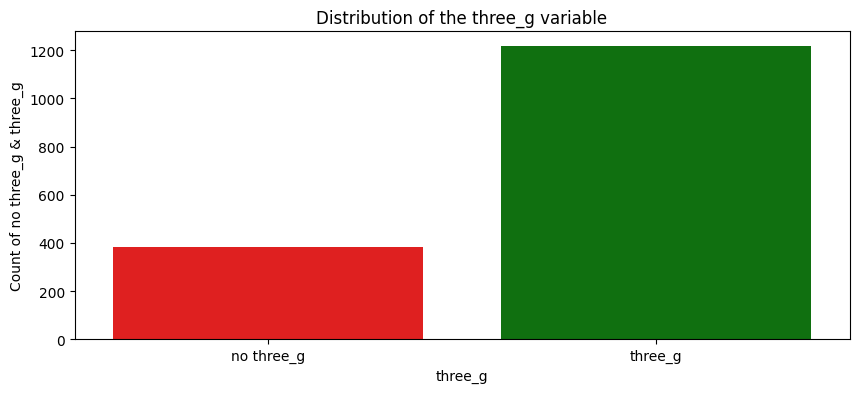

In [25]:
plot_binary_dist(df=data_train,cat_var='three_g', labels=['no three_g','three_g'])

**Comments:** <br>
- A device is more likely to have 3G 


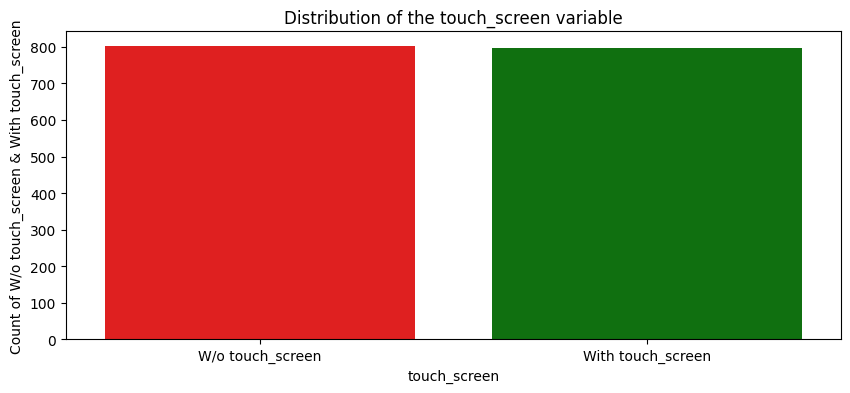

In [26]:
plot_binary_dist(df=data_train,cat_var='touch_screen', labels=['W/o touch_screen','With touch_screen'])

**Comments:** <br>
- The number of devices with a touch screen and those without are almost identical.


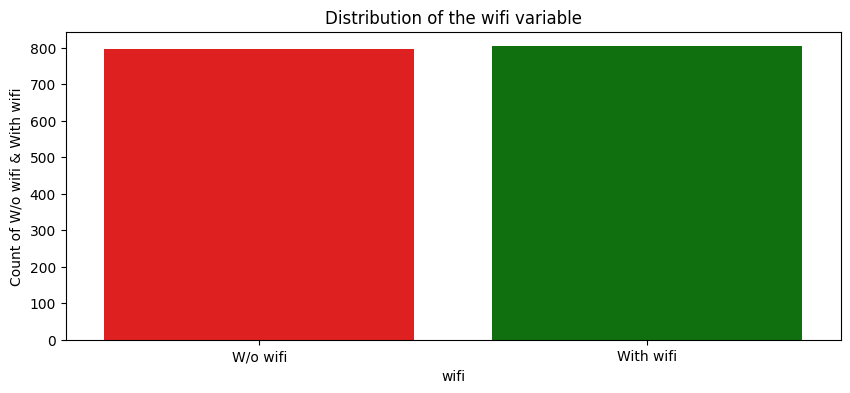

In [27]:
plot_binary_dist(df=data_train,cat_var='wifi', labels=['W/o wifi','With wifi'])

**Comments:** <br>
- The number of devices with WIFI and those without are almost identical.


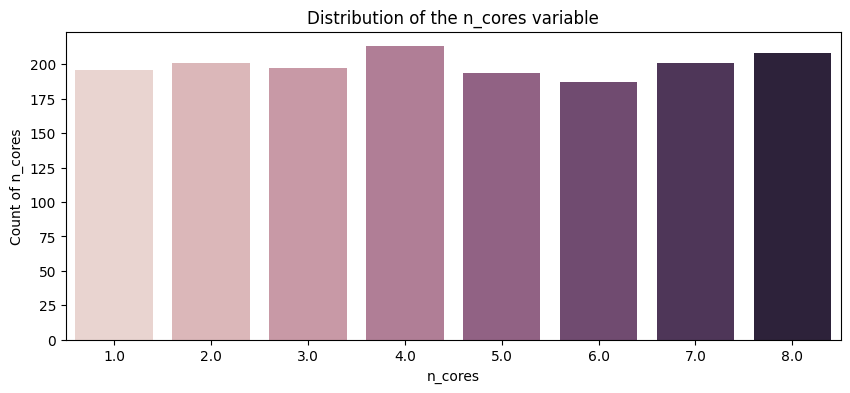

In [28]:
plot_ordinal_dist(df=data_train,cat_var='n_cores')

**Comments:** <br>
- Equal number of devices are manufactured/existing for each number of cores.
 


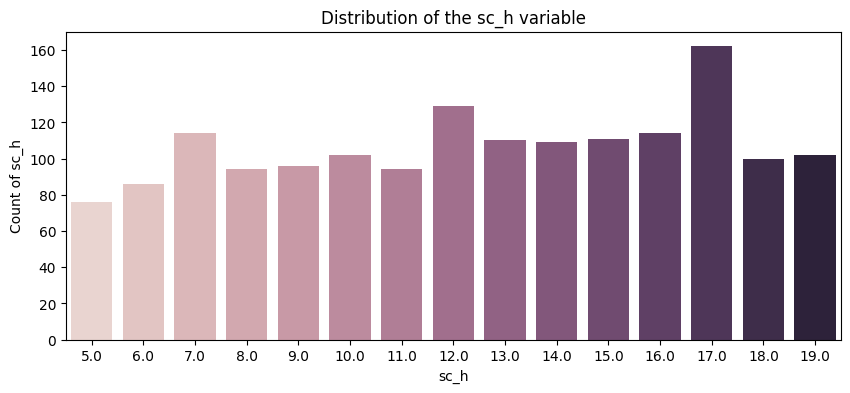

In [29]:
plot_ordinal_dist(df=data_train,cat_var='sc_h')

**Comments:** <br>
- The 


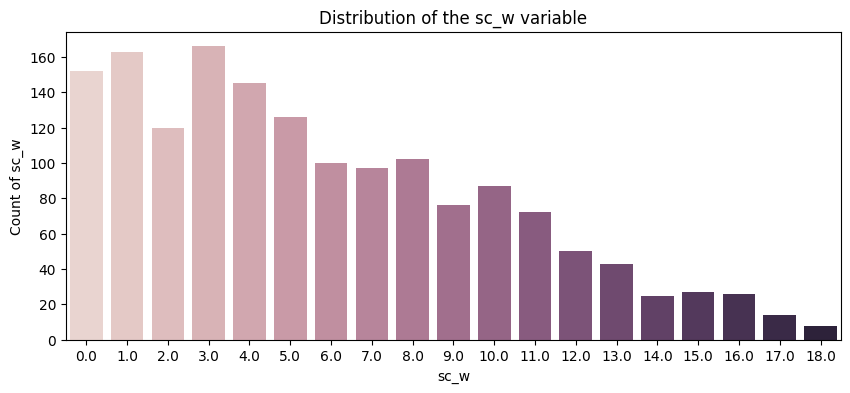

In [30]:
plot_ordinal_dist(df=data_train,cat_var='sc_w')

**Comments:** <br>
- The 


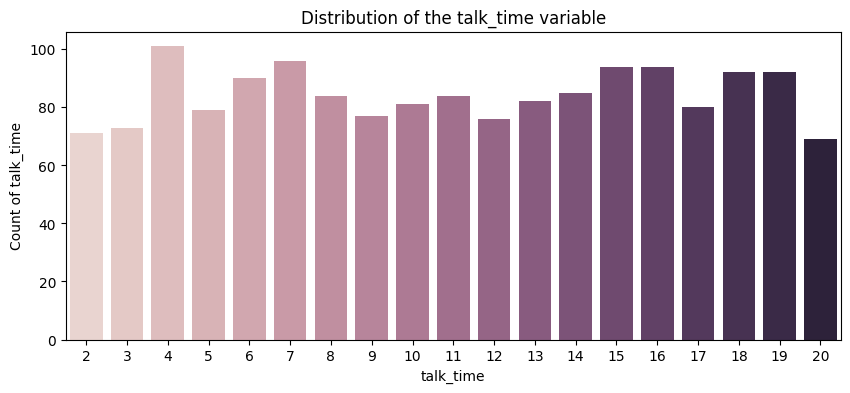

In [31]:
plot_ordinal_dist(df=data_train,cat_var='talk_time')

**Comments:** <br>
- The 


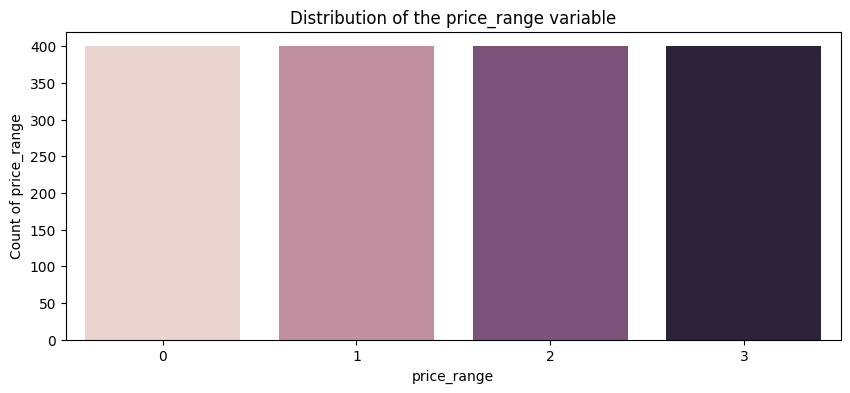

In [32]:
plot_ordinal_dist(df=data_train,cat_var='price_range')

**Comments:** <br>
- The 


### 3.4.2 Multivariate Categorical EDA

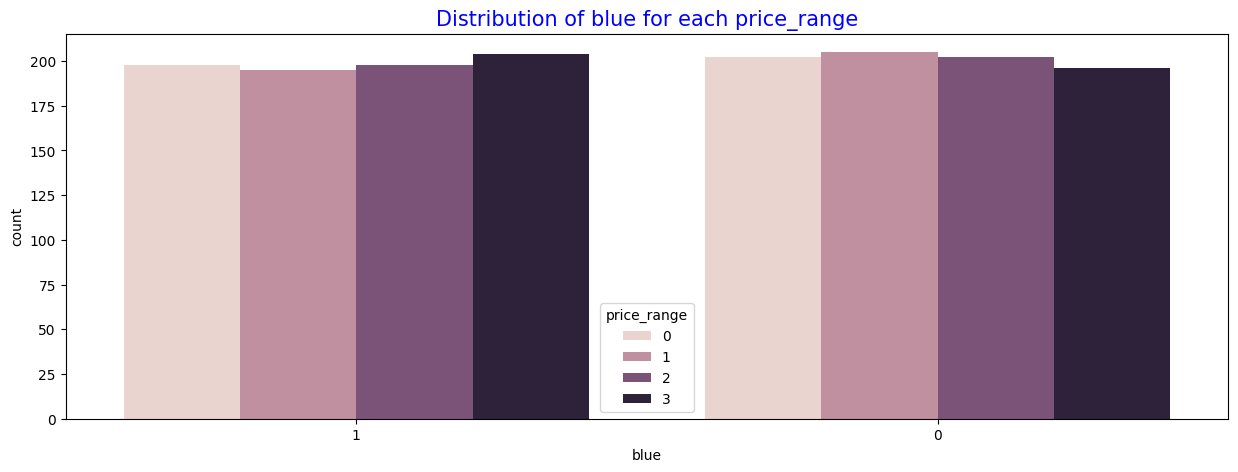

In [33]:
plot_categorical_vs_target(df= data_train,cat_var='blue',hue='price_range')

**Comments:** <br>
- The 


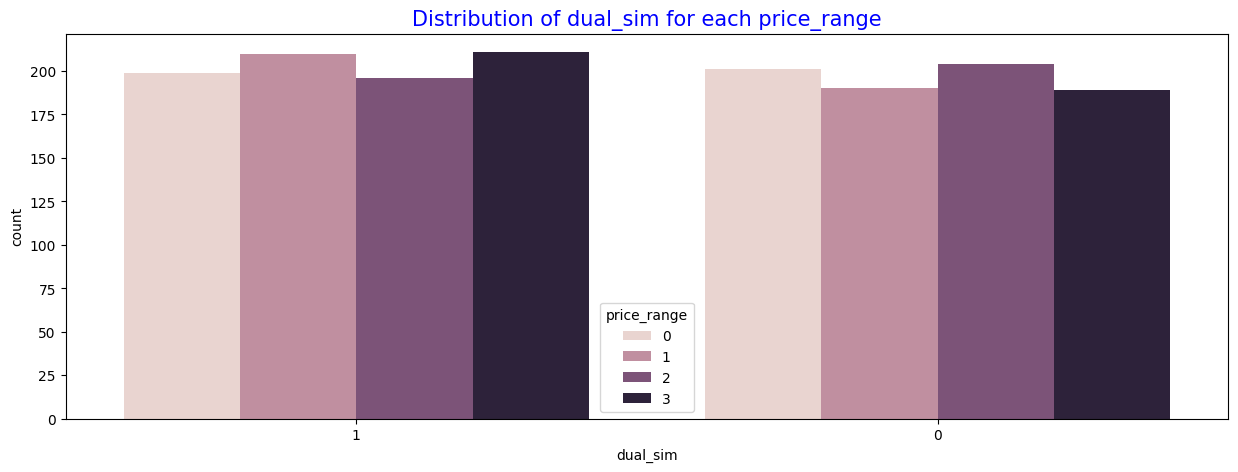

In [34]:
plot_categorical_vs_target(df= data_train,cat_var='dual_sim',hue='price_range')

**Comments:** <br>
- The 


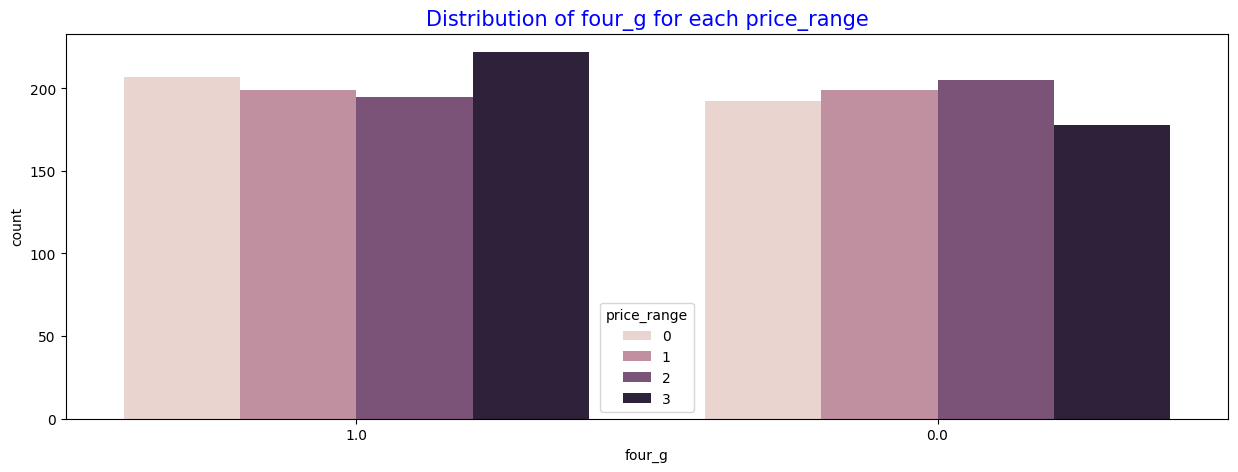

In [35]:
plot_categorical_vs_target(df= data_train,cat_var='four_g',hue='price_range')

**Comments:** <br>
- The 


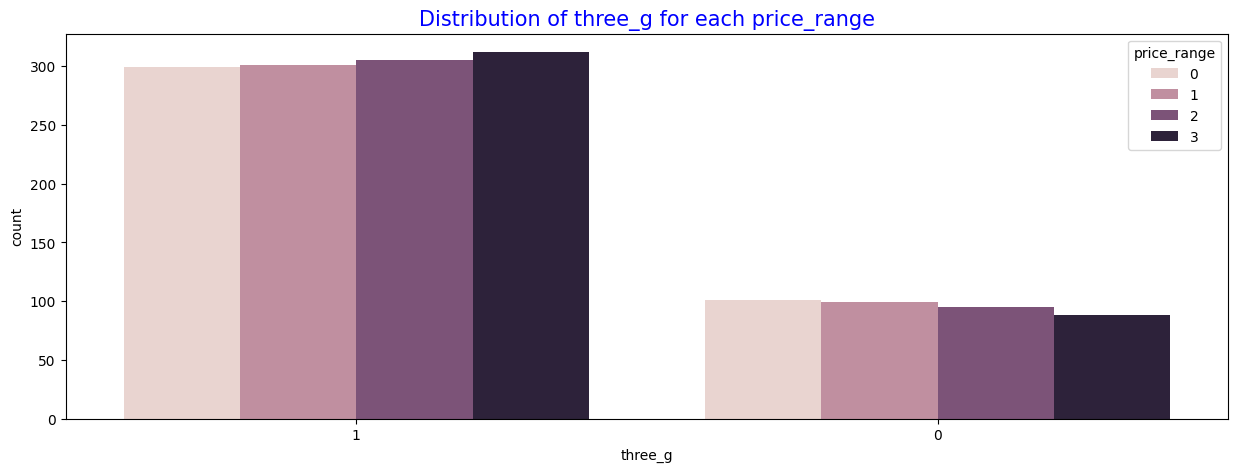

In [36]:
plot_categorical_vs_target(df= data_train,cat_var='three_g',hue='price_range')

**Comments:** <br>
- The 


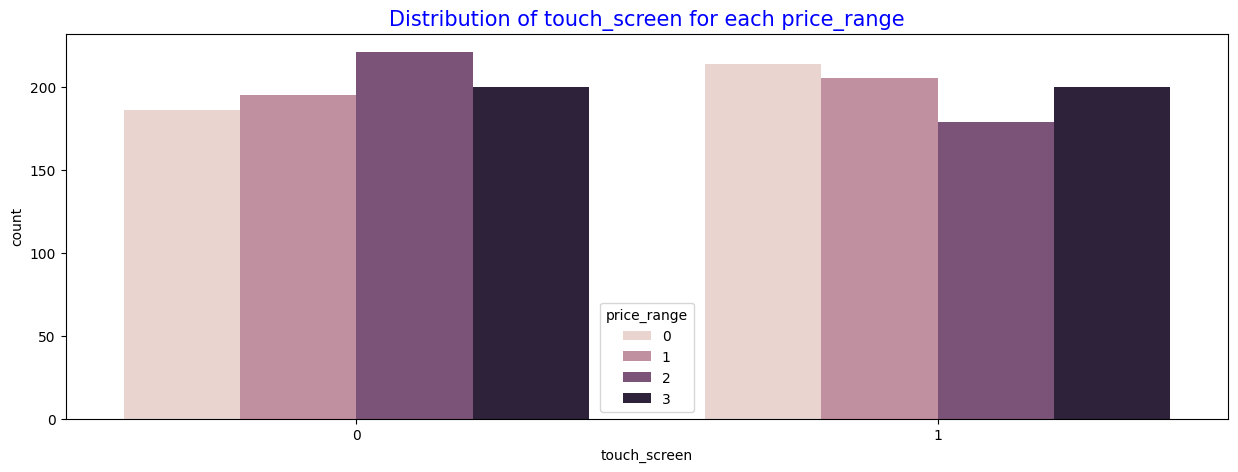

In [37]:
plot_categorical_vs_target(df= data_train,cat_var='touch_screen',hue='price_range')

**Comments:** <br>
- The 


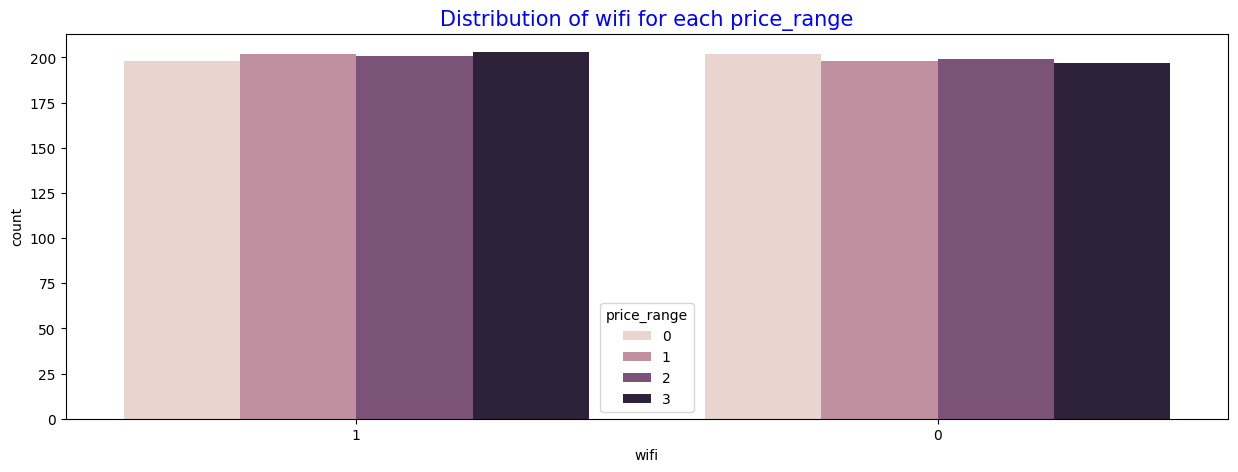

In [38]:
plot_categorical_vs_target(df= data_train,cat_var='wifi',hue='price_range')

**Comments:** <br>
- The 


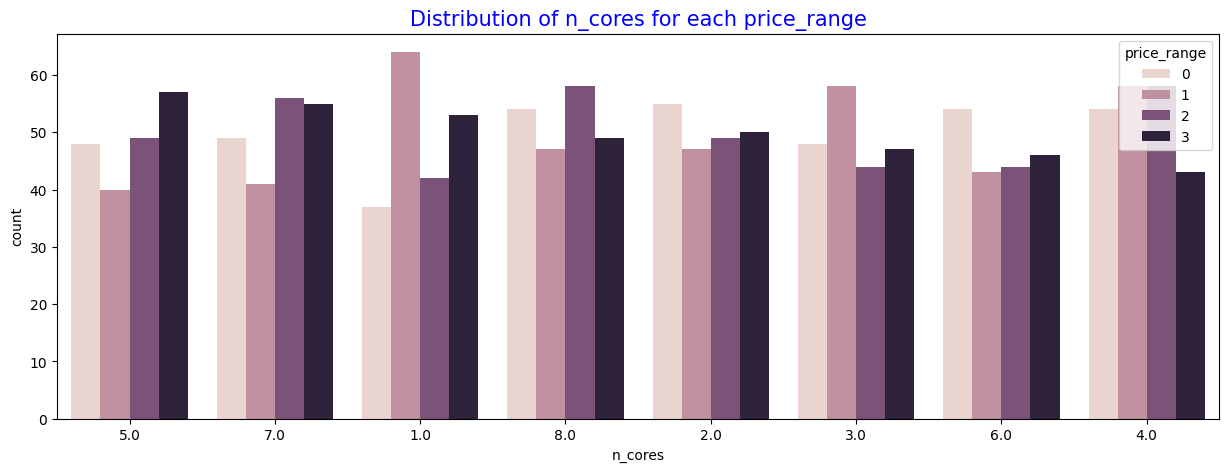

In [39]:
plot_categorical_vs_target(df= data_train,cat_var='n_cores',hue='price_range')

**Comments:** <br>
- The 


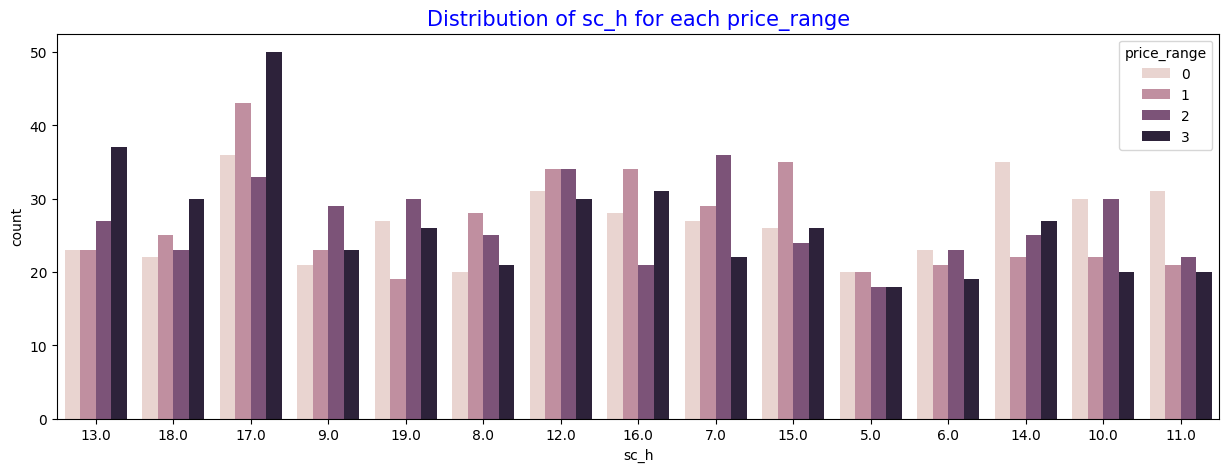

In [40]:
plot_categorical_vs_target(df= data_train,cat_var='sc_h',hue='price_range')

**Comments:** <br>
- The 


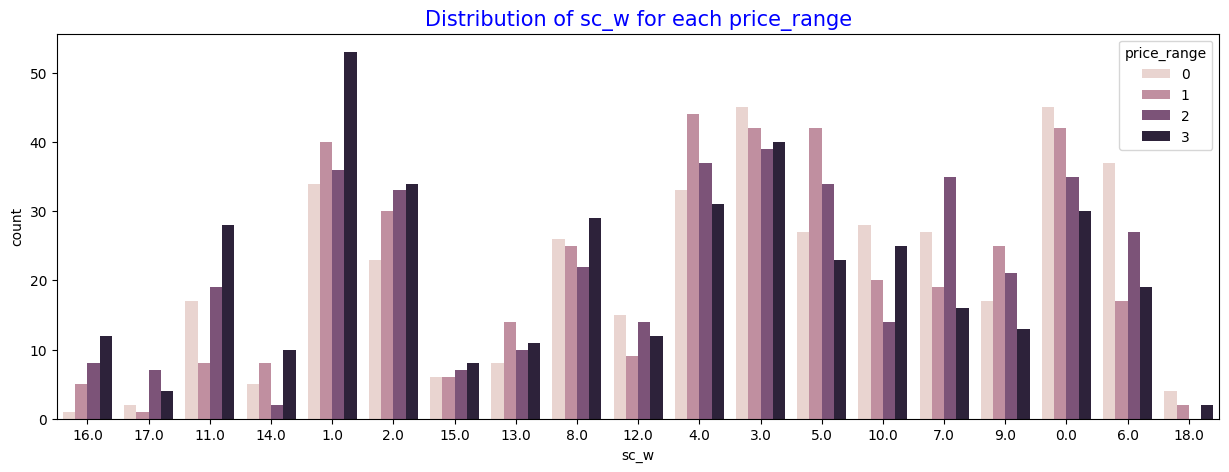

In [41]:
plot_categorical_vs_target(df= data_train,cat_var='sc_w',hue='price_range')

**Comments:** <br>
- The 


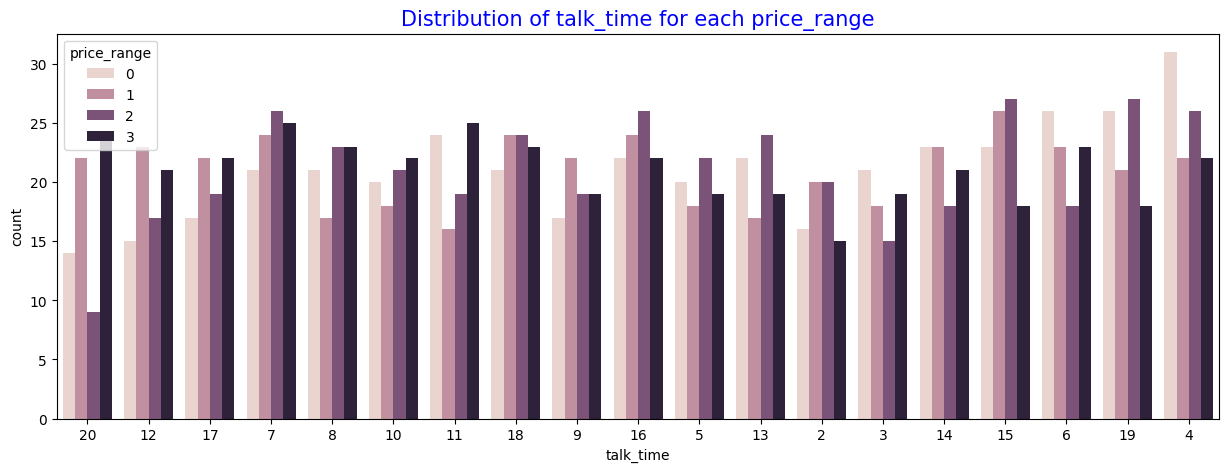

In [42]:
plot_categorical_vs_target(df= data_train,cat_var='talk_time',hue='price_range')

**Comments:** <br>
- The 


## 3.5 Multivariate Analysis

### 3.5.1 Univariate Continuous EDA

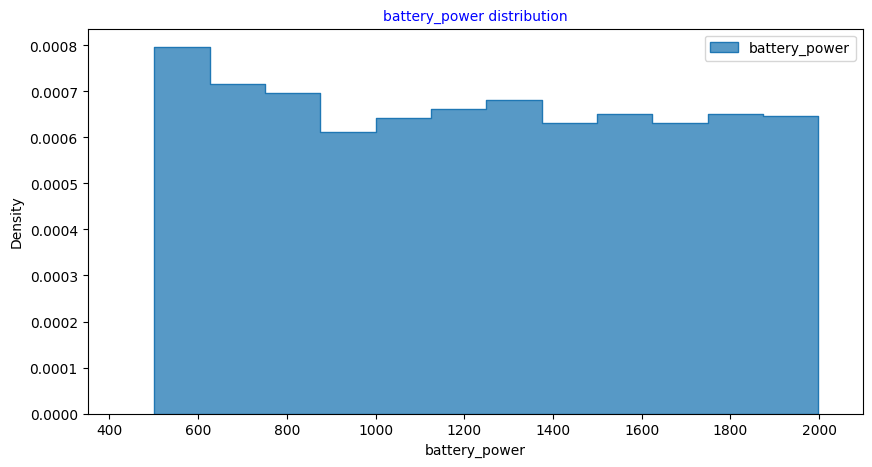

In [43]:
plot_cont_dist(df= data_train,cont_var='battery_power')

**Comments:** <br>
- The 


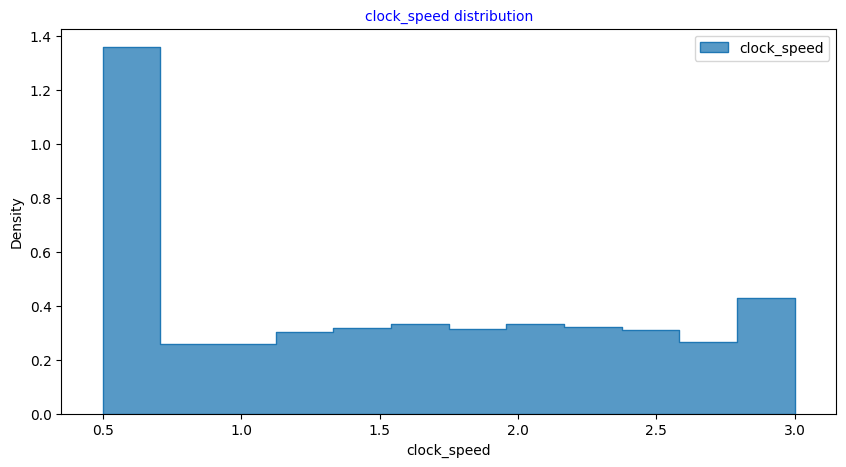

In [44]:
plot_cont_dist(df= data_train,cont_var='clock_speed')

**Comments:** <br>
- The 


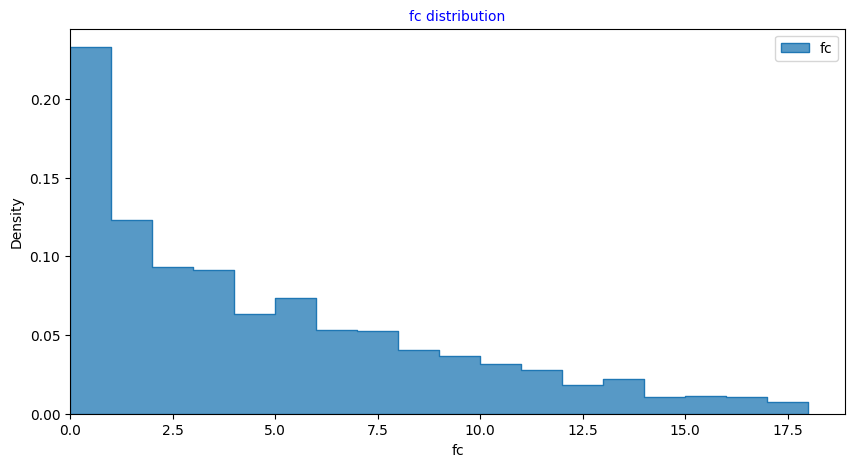

In [45]:
plot_cont_dist(df= data_train,cont_var='fc')

**Comments:** <br>
- The 


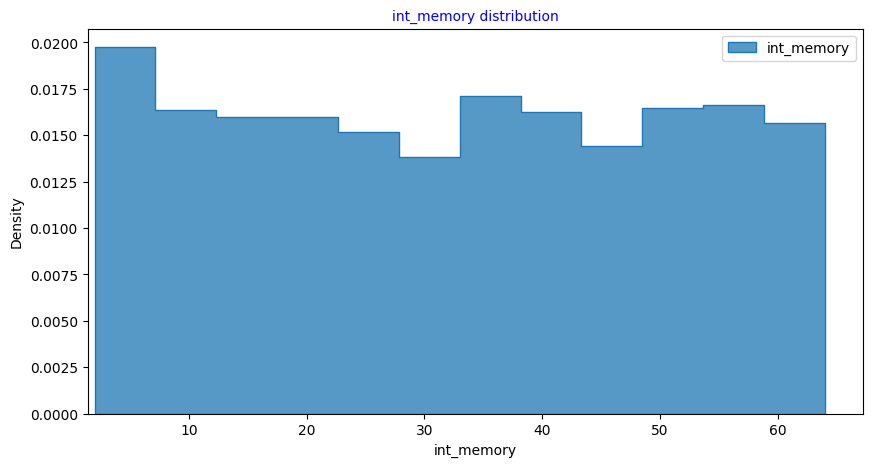

In [46]:
plot_cont_dist(df= data_train,cont_var='int_memory')

**Comments:** <br>
- The 


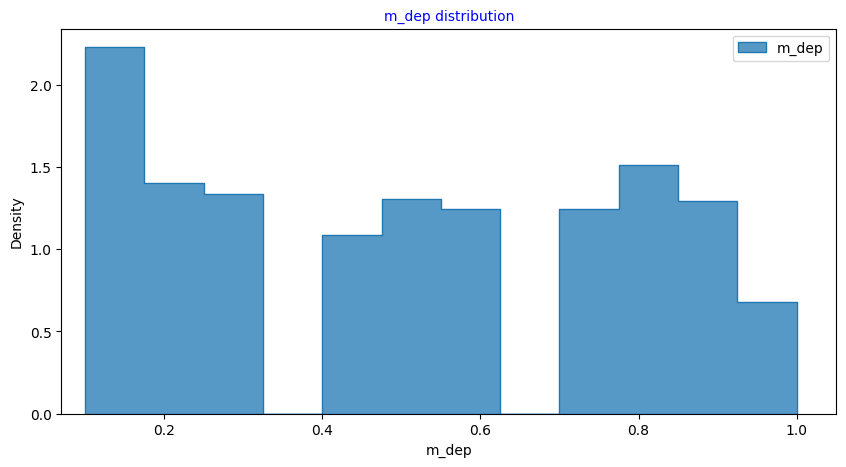

In [47]:
plot_cont_dist(df= data_train,cont_var='m_dep')

**Comments:** <br>
- The 


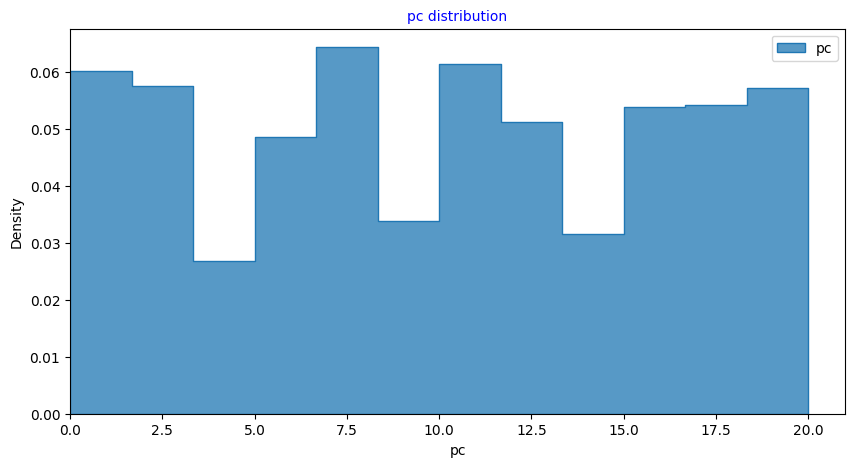

In [48]:
plot_cont_dist(df= data_train,cont_var='pc')

**Comments:** <br>
- The 


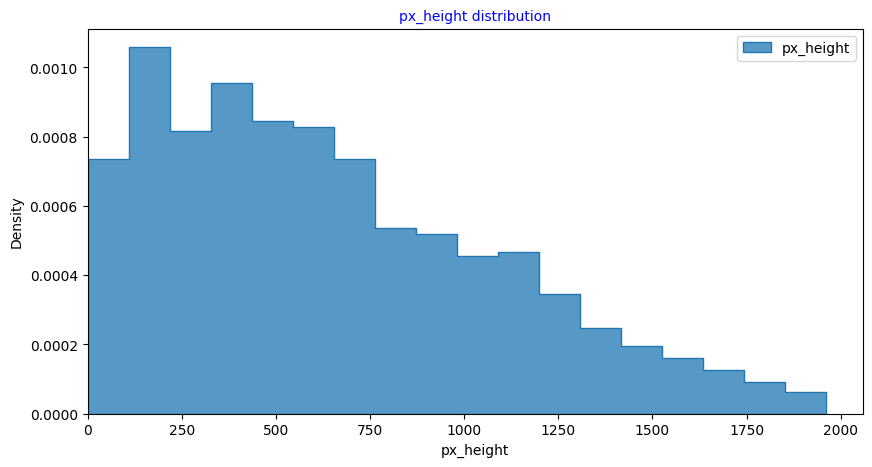

In [49]:
plot_cont_dist(df= data_train,cont_var='px_height')

**Comments:** <br>
- The 


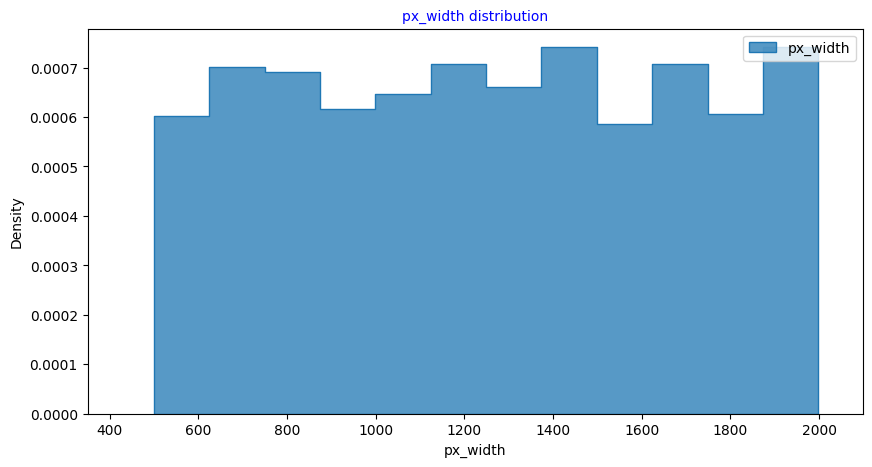

In [50]:
plot_cont_dist(df= data_train,cont_var='px_width')

**Comments:** <br>
- The 


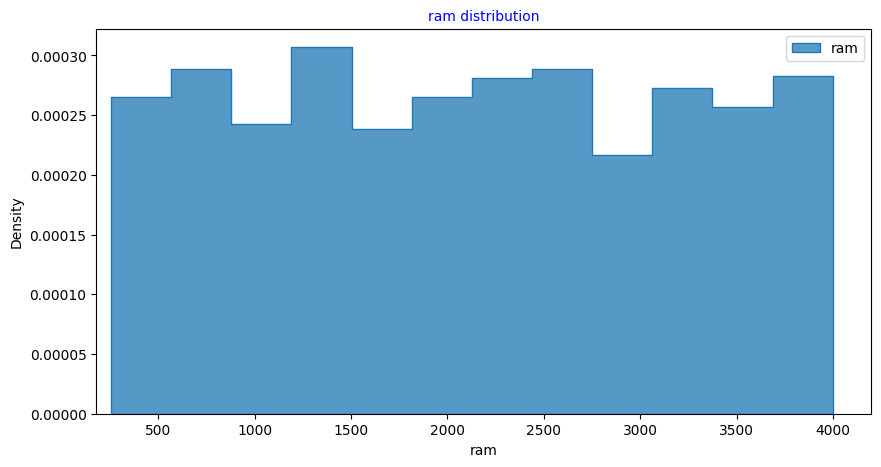

In [51]:
plot_cont_dist(df= data_train,cont_var='ram')

**Comments:** <br>
- The 


### 3.5.2 Multivariate Continuous EDA

## 3.5.2.1 Correlation Study

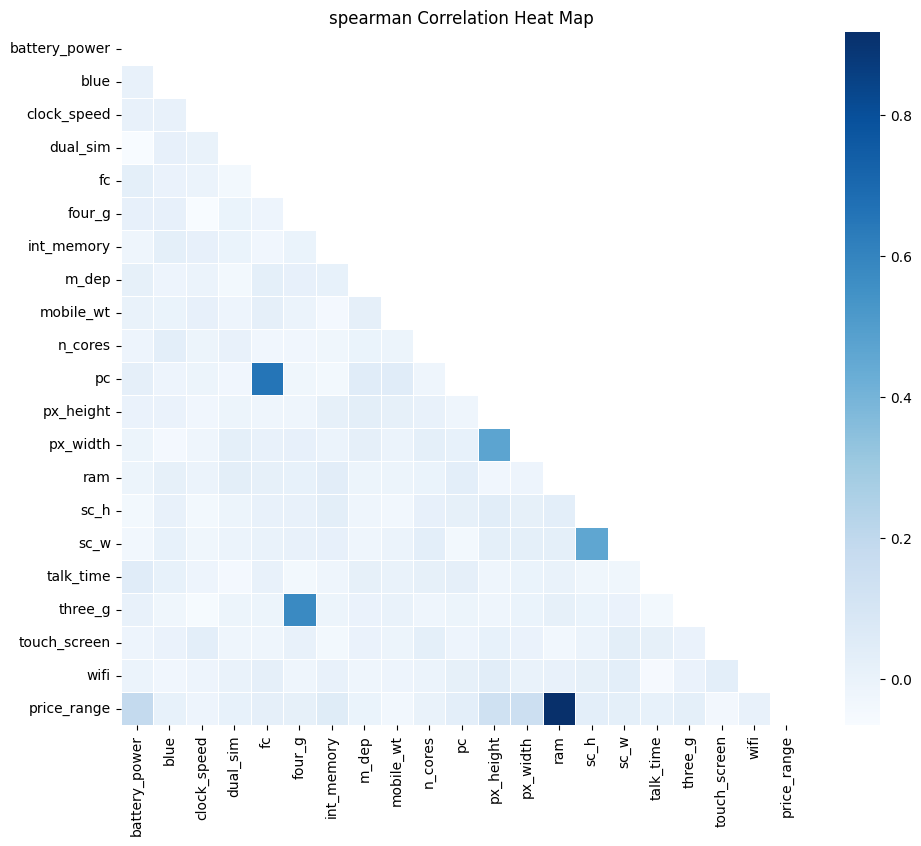

In [52]:
plot_corr(df=data_train,method='spearman',figsize=(11, 9))

# 4. Data Preprocessing


- To achieve model portability, any data preprocessing step that shall be carried out during inference will be included excplicitly in the model architecture.<br>
- Data preprocessing steps like duplication removal (will not occur in inference) will be carried out in this section.



## 4.1 Helper Classes / Functions

In [53]:
def Remove_Duplicated (df:pd.DataFrame):
    """
    Remove duplicated rows in a Pandas Dataframe and the relevant label series
   
       Parameters:
           
           df (Pandas.Dataframe) : The pandas dataframe 
       Returns:
           df is cleaned in place
   
    """
    #find indexes of the 2nd duplicate of rows
    dub = df.duplicated() 
    count = dub.sum()
    dub_mask = (dub == True)
    dub_idx = df[dub_mask].index
    #drop one of the duplicated rows from df 
    df.drop(labels = dub_idx , axis = 'index', inplace = True)   
    
    #reset the indexes of X and y (0,1,2,3,4,...., n_new)
    df.reset_index(inplace  = True,  drop = True)
    
    print (count,"duplicated rows were deleted ")
    return None

## 4.2 Remove Duplicated Rows

In [54]:
Remove_Duplicated(data_train)

0 duplicated rows were deleted 


## 4.3 Missing Data Handling

In [55]:
data_train.dropna(axis=0,how='any',inplace=True)

## 4.4 Feature Selection

 Since ANN will be our to-go model, we will rely on its capabilities for feature selection

# 4.5 Data Scaling

Will be included in the model architecure

# 5. Modeling

## 5.1 Helper Functions

In [56]:
class MlflowCallback(tf.keras.callbacks.Callback):
    """A callback to log keras metrics in the mlflow server"""
    def on_epoch_end(self, epoch, logs=None):
        mlflow.log_metric("loss", logs['loss'], step=epoch)
        mlflow.log_metric("accuracy", logs['accuracy'], step=epoch)
        if 'val_loss' in logs:
            mlflow.log_metric("val_loss", logs['val_loss'], step=epoch)
        if 'val_accuracy' in logs:
            mlflow.log_metric("val_accuracy", logs['val_accuracy'], step=epoch)

In [57]:
class LossPlotCallback(keras.callbacks.Callback):
    def on_train_begin(self,logs):
        %matplotlib qt
        self.epoch = 0
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.fig, self.axs = plt.subplots(1, 2, figsize=(12, 8))
    def on_epoch_end(self, epoch, logs=None):
            self.epoch = epoch
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.accuracies.append(logs.get('accuracy'))
            self.val_accuracies.append(logs.get('val_accuracy'))
            self.plot_loss_acc()


    def on_train_end(self,logs):
        %matplotlib inline
        self.plot_loss_acc()
    def plot_loss_acc(self):
        self.axs[0].cla()
        self.axs[0].plot(range(self.epoch+1),self.losses,
                        linestyle = '-',color='green',
                        label = 'Training Loss' )
        self.axs[0].plot(range(self.epoch+1),self.val_losses,
                        linestyle = '--',color='blue',
                        label = 'Validation Loss' )          
        self.axs[0].set_title('Loss Plot')
        self.axs[0].set_xlabel('Epoch')
        self.axs[0].set_ylabel('Loss')
        self.axs[0].legend()

        self.axs[1].cla()
        self.axs[1].plot(range(self.epoch+1), self.accuracies,
                        linestyle = '-',color='green',
                        label = 'Training Accuracy' )
        self.axs[1].plot(range(self.epoch+1), self.val_accuracies,
                        linestyle = '--',color='blue',
                        label = 'Validation Accuracy' )          
        self.axs[1].set_title('Accuracy Plot')
        self.axs[1].set_xlabel('Epoch')
        self.axs[1].set_ylabel('Accuracy')
        self.axs[1].legend()

        self.fig.canvas.draw()
        plt.show(block = False)
        plt.pause(0.001)



## 5.2 Model Architecture

In [58]:
class DataPreprocessor(keras.layers.Layer):
    """Subclasses a Keras layer class for the preprocessing of input.
    """   
     
    def __init__(self):
        self._name = 'DataPreprocessor'
        super().__init__(name=self._name)
        self.train_data = None
        # Definition and adaption of the vectorizer 
        self._pre_layers =[]
        self._pre_layers.append(keras.layers.Normalization())
          
    def summary(self):
        """A custom summary that acts similar to the original summary method.
        This method is overriden to avoid the error (model.summary() can't print output shape while using subclass model)
        """
        x = keras.Input(shape=self.train_data.shape[1], dtype=tf.float64,name='Input(in summary fun)')
        model = keras.models.Model(inputs=[x],outputs=self.call(x), name = self._name)
        return model.summary()
           
    
    def call(self, inputs):
        x=inputs
        for layer in self._pre_layers:
            x=layer(x)
        return x
    
    def adapt(self,train_data:pd.DataFrame=None):
        """Adapts the vectorizer object to the vocabulary data"""
        self.train_data=train_data
        for layer in self._pre_layers:
            layer.adapt(self.train_data)

    @classmethod
    def from_config(cls, config):
        sublayer_config = config.pop("sublayer")
        sublayer = keras.saving.deserialize_keras_object(sublayer_config)
        return cls(sublayer, **config)    


In [59]:
class ClassificationHead(keras.layers.Layer):
    """Subclasses Keras layer to encapsulate the layers used for classification.
    
    Attributes:
        num_Dense (_type_): The number of Dense hidden layers(excluding input and output layers)
        num_neurons (list): A list containing the number of neurons in each hidden layer respectively
        dropout (list): A list containing the dropout ratio after each hidden layer respectively
        activations (list): A list containing the names of activation function for each hidden layer respectively

    """

    def __init__(self,num_Dense:int,num_neurons:list,dropout:list,activations:list):
        self.model_name = 'ClassificationHead'
        super().__init__(name = self.model_name)
        
        self.num_Dense=num_Dense
        self.num_neurons=num_neurons
        self.dropout=dropout
        self.activations=activations

        self.shape=None
        # Define and initialize the proper layers
        self._layers = []

    def build(self,input_shape):
        self.shape=input_shape
        #instantiate the first layer with the deferred input shape
        self._layers.append(keras.layers.Dense(self.num_neurons[0],activation=self.activations[0],
                                               input_dim=input_shape))
        #instantiate the in-between layers
        for layer in range(1,self.num_Dense):
            self._layers.append(keras.layers.Dropout(self.dropout[layer]))            
            self._layers.append(keras.layers.Dense(units=self.num_neurons[layer],
                                                   activation=self.activations[layer]))

        #instantiate the last layer (Classification head)
        self._layers.append(keras.layers.Dropout(self.dropout[-1]))   
        self._layers.append(keras.layers.Dense(4,activation='softmax'))

    def summary(self):
        """A custom summary that acts similar to the original summary method.
        This method is overriden to avoid the error (model.summary() can't print output shape while using subclass model) 
        """
        x = keras.Input(shape=self.shape, dtype=tf.float64,name='Input(in summary fun)')
        model = keras.models.Model(inputs=[x],outputs=self.call(x), name = self.model_name)
        return model.summary()
    
    def call(self, inputs):
        x = inputs
        for layer in self._layers:
            x = layer(x)
        return x
    
    @classmethod
    def from_config(cls, config):
        sublayer_config = config.pop("sublayer")
        sublayer = keras.saving.deserialize_keras_object(sublayer_config)
        return cls(sublayer, **config)


In [60]:
class DeviceClassifier(keras.Model):
    """Subclasses Keras model to encapsulate the preprocessing layers and the classification layers in one object.
    
    Attributes:
        classifier (keras.layers.Layer): The classifier keras layer
        preprocessor (keras.layers.Layer): The preprocessing keras layer
        num_Dense (_type_): The number of Dense hidden layers(excluding input and output layers)
        num_neurons (list): A list containing the number of neurons in each hidden layer respectively
        dropout (list): A list containing the dropout ratio after each hidden layer respectively
        activations (list): A list containing the names of activation function for each hidden layer respectively
    """

    def __init__(self,classifier:keras.layers.Layer,preprocessor:keras.layers.Layer,num_Dense:int,num_neurons:list,dropout:list,activations:list,**kwargs):
        """_summary_

        Args:
            classifier (keras.layers.Layer): _description_
            preprocessor (keras.layers.Layer): _description_
            num_Dense (int): _description_
            num_neurons (list): _description_
            dropout (list): _description_
            activations (list): _description_
        """        
        self.model_name = 'DeviceClassifier'
        super().__init__(name = self.model_name)
        self.Preprocessor = preprocessor()
        self.classifier = classifier(num_Dense,num_neurons,dropout,activations, **kwargs) 
    
    def summary(self):
        """A custom summary that acts similar to the original summary method.
        This method is overriden to avoid the error (model.summary() can't print output shape while using subclass model) 
        """
        x = keras.Input(shape=self.classifier.shape, dtype=tf.float64,name='Input(in summary fun)')
        model = keras.models.Model(inputs=[x],outputs=self.call(x), name = self.model_name)
        return model.summary()
    
    def call(self, inputs):
        x = inputs
        x = self.Preprocessor(x)
        x = self.classifier(x)
        return x
    
    @classmethod
    def from_config(cls, config):
        sublayer_config = config.pop("sublayer")
        sublayer = keras.saving.deserialize_keras_object(sublayer_config)
        return cls(sublayer, **config)

    def train_model(self, compile_kwargs:dict, fit_kwargs :dict, expirement_name:str=None, run_name:str=None):
        """trains a model while keeping track of expirement and model registery.

        Args:
            compile_kwargs (dict): Keyword Arguments for keras_model.compile()
            fit_kwargs (dict): Keyword Arguments for keras_model.fit()
            expirement_name (str, optional): The expirement name for the mlflow server. Defaults to None.
            run_name (str, optional): The run name for the mlflow server. Defaults to None.

        Returns:
            _type_: _description_
        """
        # adapt the preprocessor
        self.Preprocessor.adapt(fit_kwargs['x'])
        
        # If expirement or run names are not given, set to default
        if expirement_name:
            mlflow.set_experiment(expirement_name)
        else:
            mlflow.set_experiment()
        
        if run_name:
            run_name = run_name
        else:
            run_name = ""
        
        # fit the model while tracking model parameters and metrics
        with mlflow.start_run(run_name = run_name):
            #compile the model
            self.compile(**compile_kwargs)
            
            # log model parameters (either given or the defaults)
            mlflow.log_param("epochs", fit_kwargs['epochs'])
            mlflow.log_param("batch_size", fit_kwargs['batch_size'])
            mlflow.log_param("optimizer_name", self.optimizer.name)
            mlflow.log_param("optimizer_learning_rate", self.optimizer.learning_rate.numpy())
            mlflow.log_param("optimizer_beta_1", self.optimizer.beta_1)
            mlflow.log_param("optimizer_beta_2", self.optimizer.beta_2)
            mlflow.log_param("optimizer_epsilon", self.optimizer.epsilon)
            mlflow.log_param("loss_name", self.loss.name)
            
            # fit method callbacks
            mlflow_callback = MlflowCallback()         # to log in mlfow server
            plot_callback = LossPlotCallback()         # to draw the learning curves dynamically
            fit_kwargs['callbacks'] = [mlflow_callback,plot_callback]
            
            # fitting the model
            history = self.fit(**fit_kwargs)

            # Evaluate the model
            loss, accuracy = self.evaluate(fit_kwargs['x'],fit_kwargs['y'])
            mlflow.log_metric("loss", loss)
            mlflow.log_metric("accuracy", accuracy)

            #log the validation metrics
            if 'validation_data' in fit_kwargs:
                validation_data = fit_kwargs['validation_data']
                val_loss, val_accuracy = self.evaluate(validation_data[0], validation_data[1])
                mlflow.log_metric("val_loss", val_loss)
                mlflow.log_metric("val_accuracy", val_accuracy)
                
        mlflow.end_run()


        return history
    

## 5.3 First Expirement

2024-05-03 22:26:46.340644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:26:46.373995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:26:46.374034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:26:46.379607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:26:46.379659: I external/local_xla/xla/stream_executor

Epoch 1/100


2024-05-03 22:26:53.648084: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f76cc02b370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-03 22:26:53.648166: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-05-03 22:26:53.654436: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-03 22:26:54.098265: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1714764414.155089   86817 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 4s 26ms/step - loss: 1.4842 - accuracy: 0.2662 - val_loss: nan - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 1.4298 - accuracy: 0.2731 - val_loss: nan - val_accuracy: 0.2450
Epoch 3/100
25/25 [==============================] - 1s 21ms/step - loss: 1.3963 - accuracy: 0.2881 - val_loss: nan - val_accuracy: 0.2625
Epoch 4/100
25/25 [==============================] - 0s 18ms/step - loss: 1.3724 - accuracy: 0.2963 - val_loss: nan - val_accuracy: 0.2750
Epoch 5/100
25/25 [==============================] - 0s 18ms/step - loss: 1.3539 - accuracy: 0.3139 - val_loss: nan - val_accuracy: 0.3075
Epoch 6/100
25/25 [==============================] - 0s 20ms/step - loss: 1.3367 - accuracy: 0.3289 - val_loss: nan - val_accuracy: 0.3300
Epoch 7/100
25/25 [==============================] - 0s 18ms/step - loss: 1.3193 - accuracy: 0.3434 - val_loss: nan - val_accuracy: 0.3550
Epoch 8/100
25/25 [====================

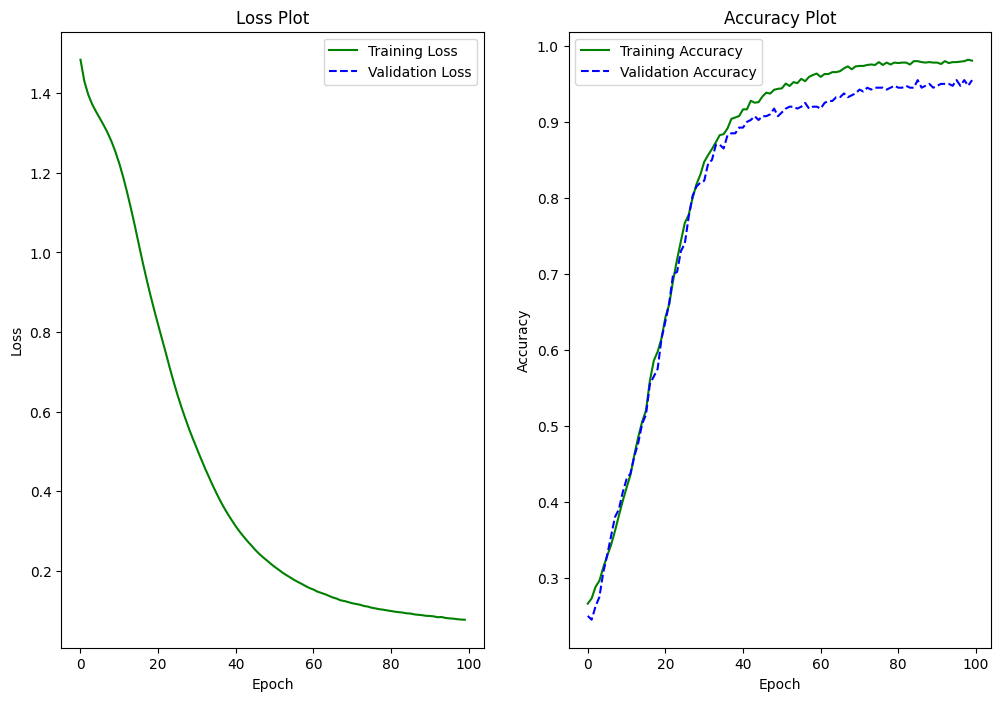

13/13 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.9550


In [61]:
classifier= DeviceClassifier(ClassificationHead,DataPreprocessor,2,[5,10],[0,0],['relu','relu'])
compile_kwargs = { 'loss': keras.losses.SparseCategoricalCrossentropy() ,
                    'optimizer':'adam',
                    'metrics':['accuracy']}
                    
fit_kwargs = {'x': data_train.iloc[:,:-1], 'y' :data_train.iloc[:,-1] , 'validation_data' : (data_val.iloc[:,:-1], data_val.iloc[:,-1]),
               'epochs':100, 'batch_size' : 64}
classifier.train_model(compile_kwargs, fit_kwargs,expirement_name= '2layers-5/10-relu',run_name= '(1)')

# 6. Evaluation

# 7. Model API